# Телеком

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Нам предоставили данные о некоторых клиентах, информацию об их тарифах и договорах.

## Первичный анализ данных

In [2]:
#pip install seaborn

     -------------------------------------- 293.3/293.3 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 7.6/7.6 MB 4.1 MB/s eta 0:00:00
     -------------------------------------- 470.9/470.9 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 3.2 MB/s eta 0:00:00
     -------------------------------------- 55.4/55.4 kB 960.7 kB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve
from sklearn.compose import make_column_transformer


In [2]:
try:
    contract = pd.read_csv(r'/datasets/contract_new.csv')
    personal = pd.read_csv(r'/datasets/personal_new.csv')
    internet = pd.read_csv(r'/datasets/internet_new.csv')
    phone = pd.read_csv(r'/datasets/phone_new.csv')
except:
    contract = pd.read_csv(r'C:\Users\1\Downloads\contract_new.csv')
    personal = pd.read_csv(r'C:\Users\1\Downloads\personal_new.csv')
    internet = pd.read_csv(r'C:\Users\1\Downloads\internet_new.csv')
    phone = pd.read_csv(r'C:\Users\1\Downloads\phone_new.csv')

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Для дальнейшей работы нам понадобится объединить 4 таблицы по полю customerID.

В таблицах нет пропущенных значений.

В 2 из них количество строк одинаково (contract, personal). В оставшихся строк меньше, и при склейке таблиц появятся пропущенные значения, которые нужно будет обработать.


In [11]:
# объединение таблиц

df_1 = contract.merge(personal, on='customerID', how='left')
df_2 = df_1.merge(internet,  on='customerID', how='left')
df = df_2.merge(phone,  on='customerID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [12]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Многие колонки типа object содержат данные, которые можно интерпретировать как булевы - да/нет или 1/0. (PaperlessBilling, Partner, Dependents, OnlineSecurity,OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines)

В колонке TotalCharges тип object, но дожен быть float64


In [13]:
# Обработаем пропуски:

df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Посмотрим на уникальные значения колонок с пропусками

In [14]:
pass_list = ['InternetService','PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity','OnlineBackup',
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for p in pass_list:
    print(p, df[p].unique())

InternetService ['DSL' 'Fiber optic' nan]
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
OnlineSecurity ['No' 'Yes' nan]
OnlineBackup ['Yes' 'No' nan]
DeviceProtection ['No' 'Yes' nan]
TechSupport ['No' 'Yes' nan]
StreamingTV ['No' 'Yes' nan]
StreamingMovies ['No' 'Yes' nan]
MultipleLines [nan 'No' 'Yes']


Эти значения можно заменить на No


In [15]:
for p in pass_list:
    df[p] = df[p].fillna('No')


In [16]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Пропущенных данных в колонке EndDate нет. Если человек продолжает пользоваться услугами, то в этом поле прописано No. По этим данным нужно будет создать целевой признак, а также новый признак с количеством времени пользования услугами для всех клиентов

In [17]:
df['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [18]:
df['enjoys'] = (df['EndDate'] != 'No').astype(int)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,enjoys
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


Оценим количество пользующихся услугами людей и отказавшимися от них

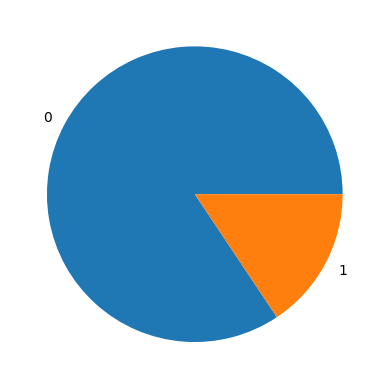

In [19]:
a = df['enjoys'].sum()
b = 7043 - a
lists = [b, a]
labels = [0, 1]
plt.pie(lists, labels=labels)
plt.show()

Большенство клиентов с 2014 по 2020 год всё ещё пользуются услугами компании.

Создадим новый признак: duration - количество дней пользования услугами


In [20]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [21]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,enjoys
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [22]:
L = ['BeginDate', 'EndDate']
for l in L:
    df[l] = pd.to_datetime(df[l], format='%Y-%m-%d')

df['duration'] = (df['EndDate'] - df['BeginDate']).dt.days
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,enjoys,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Изменим признак SeniorCitizen и сделаем его категориальным

In [23]:
df.loc[df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
df.loc[df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'

Обработаем признак TotalCharges. В нём присутствуют пробелы в тех строках, BeginDate которых 2020-02-01. Это данные новых клиентов, поэтому приравняем их общие траты к тратам за месяц, а также приведём тип к float64

In [24]:
df.loc[df['TotalCharges'] == ' '].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,enjoys,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,No,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,No,...,No,No,No,No,No,No,No,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,No,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,No,...,No,No,No,No,No,No,No,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,No,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0


In [25]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = df.loc[df['TotalCharges'] == ' ', 'MonthlyCharges']

df['TotalCharges'] = df['TotalCharges'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Посмотрим на графики с данными о длительности пользования услугами, трат в месяц, даты начала пользования услугами, общими тратами

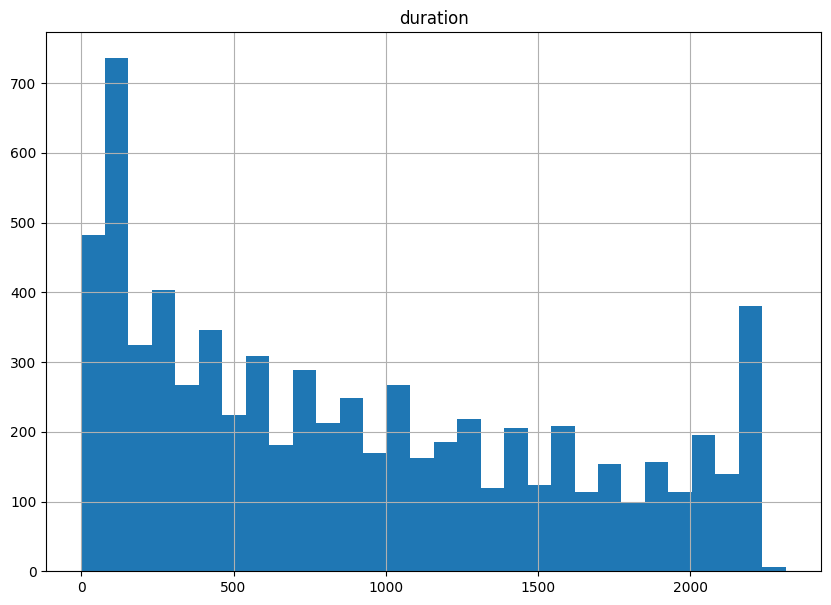

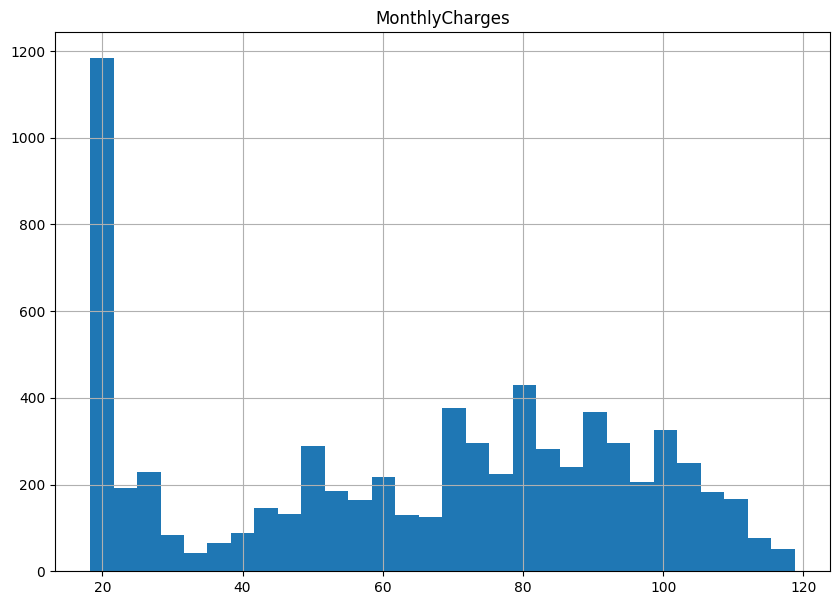

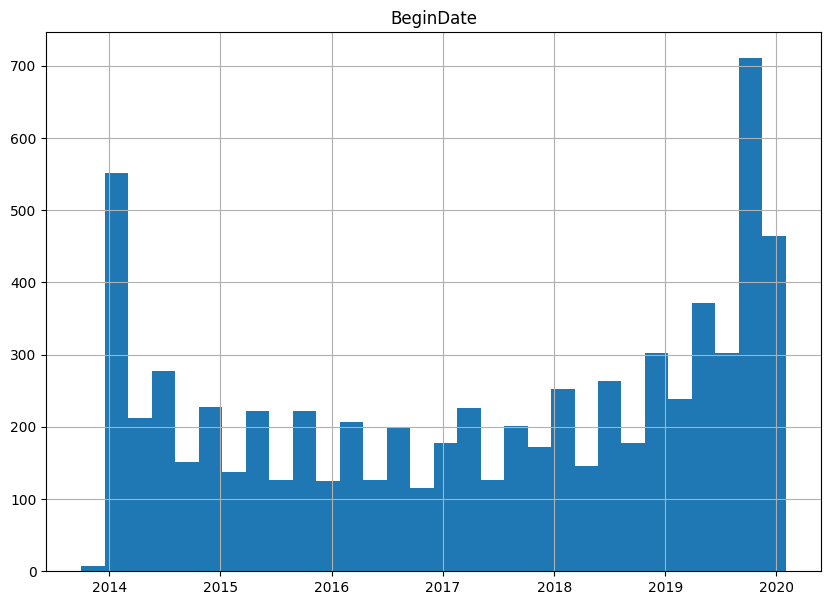

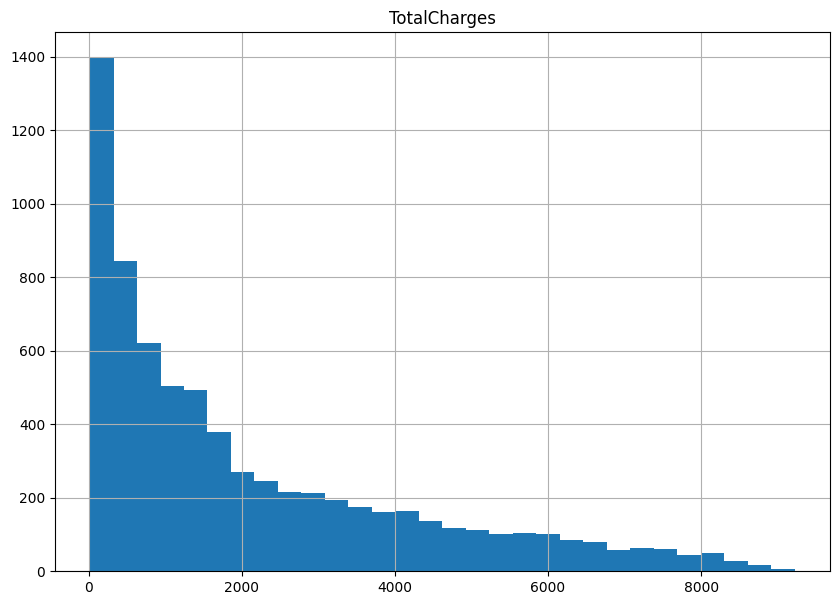

In [26]:
H = ['duration', 'MonthlyCharges', 'BeginDate', 'TotalCharges']

for h in H:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
     
    y = df[h]
    ax.hist(y, 30)
    ax.grid()
    plt.title(h)
    plt.show()

Посмотрим числовые признаки данных

In [27]:
df.describe()

,BeginDate,EndDate,MonthlyCharges,TotalCharges,enjoys,duration
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,64.761692,2115.377573,0.156325,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,0.000000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,0.000000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,0.000000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,1.000000,2314.000000
std,NaN,NaN,30.090047,2112.678861,0.363189,683.130510


На графиках и в таблице видно, что:
- Чаще всего клиенты пользуются услугами оператора меньше года
- У оператора есть большая база постоянных клиентов пользующихся услугами на протяжении всех 6 лет
- Траты большого количества клиентов в месяц не привышают 25 рублей
- Общие траты большенства клиентов не привышают 2000 рублей
- Компания переживает подъём с 2018 года, происходит постоянный приток клиентов
- Резкий скачок был достигнут в конце 2019 года, поэтому такое большое количество клиентов пользуется услугами меньше года
- Числовые признаки MonthlyCharges, TotalCharges, duration выглядят адекватно

Изучим корреляцию признаков


C:\Users\1\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


<Axes: >

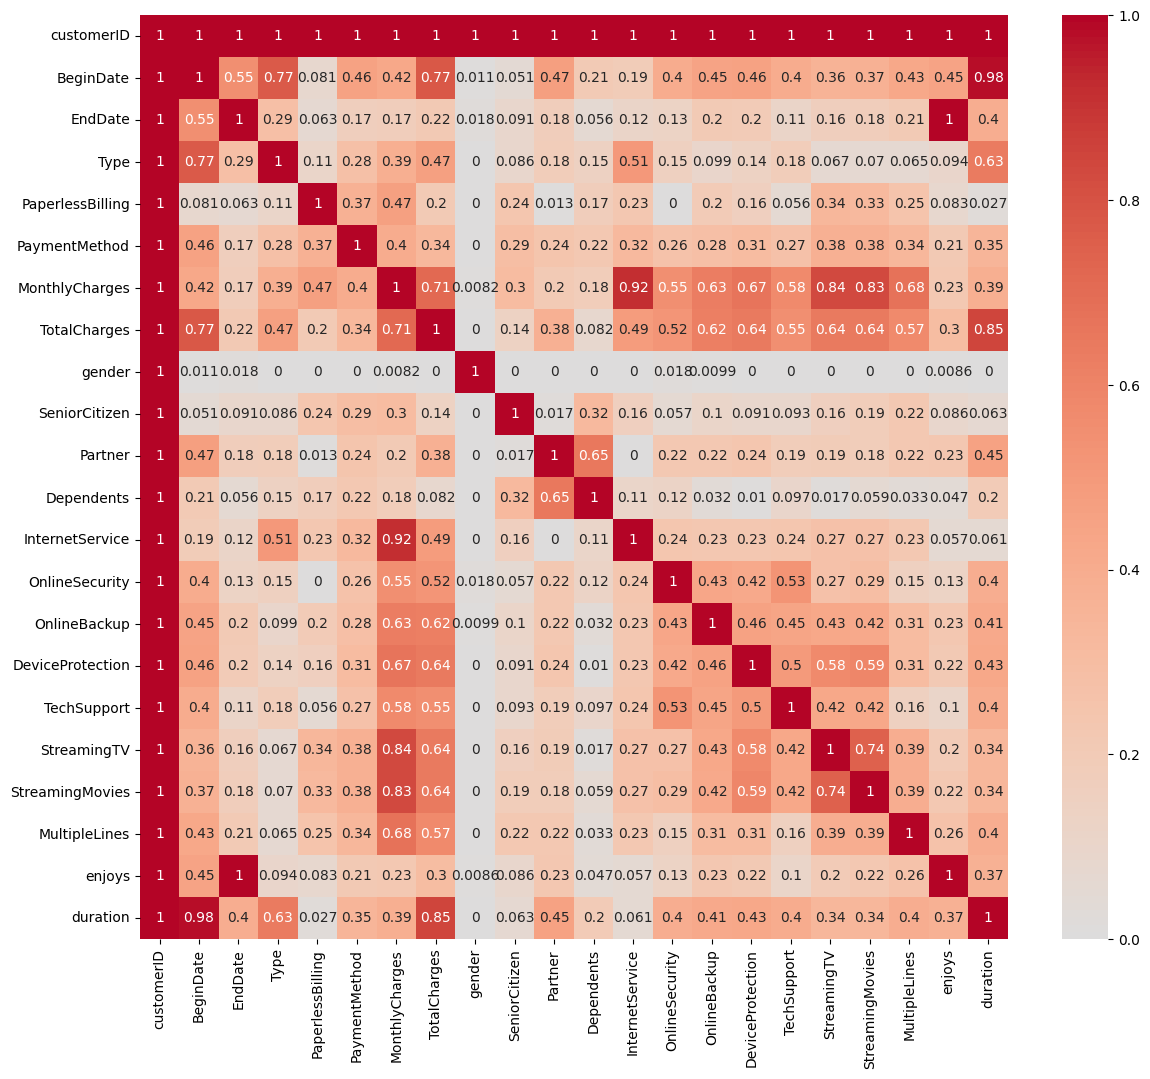

In [28]:
corr_matrix = phik_matrix(df, interval_cols=['enjoys', 'MonthlyCharges', 'TotalCharges', 'duration'])

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot = True, vmin=0, vmax=1, center= 0, cmap= 'coolwarm')

Исходя из полученных данных корреляции можно сделать выводы:
- нужно удалить признаки: customerID, EndDate, BeginDate
- новый признак duration хорошо коррелирует с целевым признаком enjoys, это может помочь улучшить качество модели

***Примерный план решения задачи.***

1) подготовка данных к машинному обучению
- удалить признаки выявленные выше
- деление на выборки
- кодирование

2) Обучение моделей кросс-валидацией с перебором параметров и использованием пайплана
- Логистическая регрессия(С) , Случайный лес (max_depth, n_estimators), Кат-буст (max_depth, learning_rate)

3) Тестирование лучшей модели на тестовой выборке

4) Выводы

***Цель проекта.***

Создать модель с метрикой ROC-AUC >= 0.85, которая сможет прогнозировать отток клиентов, а также презентовать её оператору связи «Ниединогоразрыва.ком» с дополнительными более интерпретируемыми метриками. Сделать убедительный проект, показывающий эффективность применения машинного обучения для данной задачи.

## Обработка данных

In [29]:
# Удаляем признаки

df = df.drop(['customerID', 'EndDate', 'BeginDate', 'gender'], axis=1)
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,enjoys,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [30]:
# Создаём признаки и делим данные на выборки
target = df['enjoys']
features = df.drop(['enjoys'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=60623, stratify=target)

Подготовка данных завершена, можно приступать к созданию моделей

## Обучение моделей

***Проверим RandomForest***

In [34]:
ohe_features_rf = features_train.select_dtypes(include='object').columns.to_list()
#ohe_features_rf.remove('model')
col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(random_state=60623, class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15)
}

gs_rf = GridSearchCV(
    pipline_rf, 
    param_grid=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1, cv=5)

gs_rf.fit(features_train, target_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'Лучшая метрика roc_auc: {gs_rf_best_score}')
print(f'Лучшие параметры: {gs_rf_best_params}')

Лучшая метрика roc_auc: 0.8090958468079592
Лучшие параметры: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 250}


***Проверим LogisticRegression***

In [37]:
col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    remainder='passthrough'
)

model_lr = LogisticRegression(class_weight='balanced', random_state=60623)
param_grid_lr = {'logisticregression__C': range(2, 15),
                 'logisticregression__max_iter': range(150, 250, 10)
                }
pipline_lr = make_pipeline(col_transformer_rf, model_lr)
gs_lr = GridSearchCV(
    pipline_lr, 
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1, cv=5)

gs_lr.fit(features_train, target_train)

gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_
print(f'Лучшая метрика roc_auc: {gs_lr_best_score}')
print(f'Лучшие параметры: {gs_lr_best_params}')

Лучшая метрика roc_auc: 0.7546953939283471
Лучшие параметры: {'logisticregression__C': 8, 'logisticregression__max_iter': 190}


***Проверим CatBoost***

In [40]:
param_grid_cat = {
    'catboostclassifier__max_depth': [2, 3, 4, 5],
    'catboostclassifier__learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7]
}

model_cat = CatBoostClassifier(iterations=200, random_state=60623, auto_class_weights='Balanced')
pipline_cat = make_pipeline(col_transformer_rf, model_cat)
gs_cat = GridSearchCV(
    pipline_cat, 
    param_grid=param_grid_cat, 
    scoring='roc_auc', 
    n_jobs=-1, cv=5)

gs_cat.fit(features_train, target_train)

gs_cat_best_score = gs_cat.best_score_
gs_cat_best_params = gs_cat.best_params_
print(f'Лучшая метрика roc_auc: {gs_cat_best_score}')
print(f'Лучшие параметры: {gs_cat_best_params}')

0:	learn: 0.6563645	total: 162ms	remaining: 32.3s
1:	learn: 0.6086473	total: 170ms	remaining: 16.8s
2:	learn: 0.5866617	total: 176ms	remaining: 11.6s
3:	learn: 0.5602612	total: 183ms	remaining: 8.96s
4:	learn: 0.5527290	total: 186ms	remaining: 7.25s
5:	learn: 0.5431357	total: 189ms	remaining: 6.11s
6:	learn: 0.5355051	total: 192ms	remaining: 5.3s
7:	learn: 0.5309321	total: 196ms	remaining: 4.7s
8:	learn: 0.5225140	total: 199ms	remaining: 4.23s
9:	learn: 0.5191545	total: 203ms	remaining: 3.85s
10:	learn: 0.5187052	total: 206ms	remaining: 3.54s
11:	learn: 0.5133613	total: 210ms	remaining: 3.28s
12:	learn: 0.5096268	total: 213ms	remaining: 3.06s
13:	learn: 0.5073489	total: 216ms	remaining: 2.87s
14:	learn: 0.5054162	total: 219ms	remaining: 2.7s
15:	learn: 0.5016631	total: 221ms	remaining: 2.54s
16:	learn: 0.4994441	total: 223ms	remaining: 2.4s
17:	learn: 0.4971611	total: 224ms	remaining: 2.27s
18:	learn: 0.4928422	total: 226ms	remaining: 2.15s
19:	learn: 0.4910179	total: 228ms	remaining: 

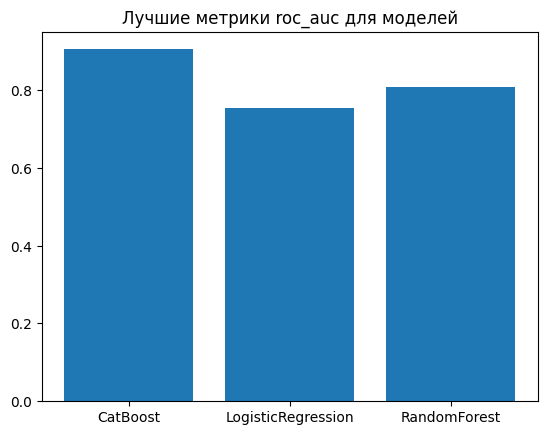

In [43]:
#x = [best_score_cat, best_score_LR, best_score]
index = ['CatBoost', 'LogisticRegression', 'RandomForest']
values = [gs_cat_best_score, gs_lr_best_score, gs_rf_best_score]
plt.bar(index,values)
plt.title('Лучшие метрики roc_auc для моделей')
plt.show()

Лучший результат roc_auc показала бустинговая модель CatBoost (0.9) с параметрами: learning_rate: 0.6, max_depth: 2

Проверим её на тестовой выборке

## Тестирование модели

In [44]:
pred_proba_test = gs_cat.predict_proba(features_test)[::,1]
pred_test = gs_cat.predict(features_test)
roc_auc_test = roc_auc_score(target_test, pred_test)
accuracy_test = accuracy_score(target_test, pred_test)
print('roc_auc на test', roc_auc_test)
print("accuracy на test: ", accuracy_test)

roc_auc на test 0.8694579713691423
accuracy на test:  0.8972174900624645


In [45]:
confusion_matrix(target_test, pred_test)

array([[1352,  134],
       [  47,  228]], dtype=int64)

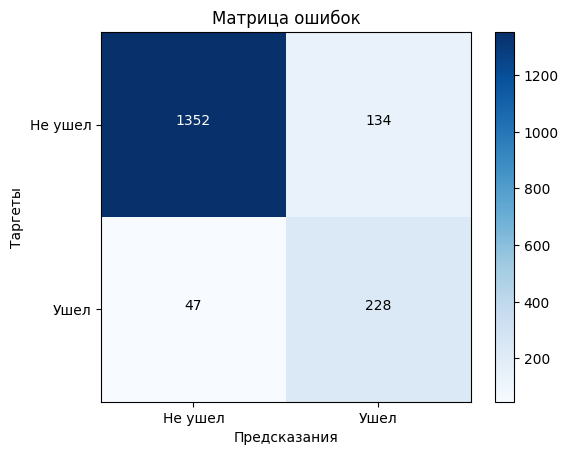

In [46]:
conf_matrix = confusion_matrix(target_test, pred_test)
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Не ушел', 'Ушел'])
plt.yticks(tick_marks, ['Не ушел', 'Ушел'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.xlabel('Предсказания')
plt.ylabel('Таргеты')
plt.title('Матрица ошибок')

plt.show()

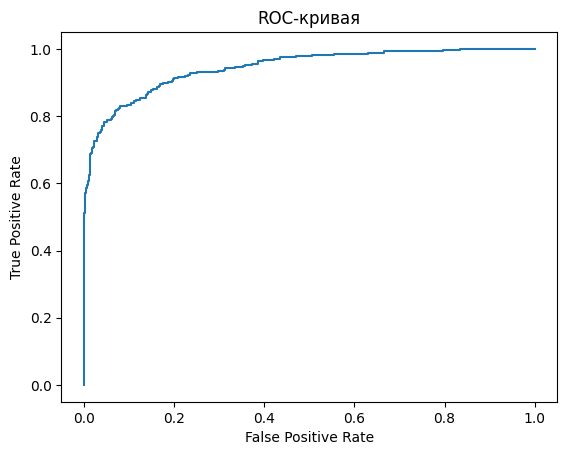

In [47]:
#y_pred_proba = pipeline_cat.predict_proba(features_test)[::,1]
fpr, tpr, _ = roc_curve (target_test, pred_proba_test)

plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [48]:
best_model = gs_cat.best_estimator_.named_steps['catboostclassifier']

<Axes: ylabel='Признаки'>

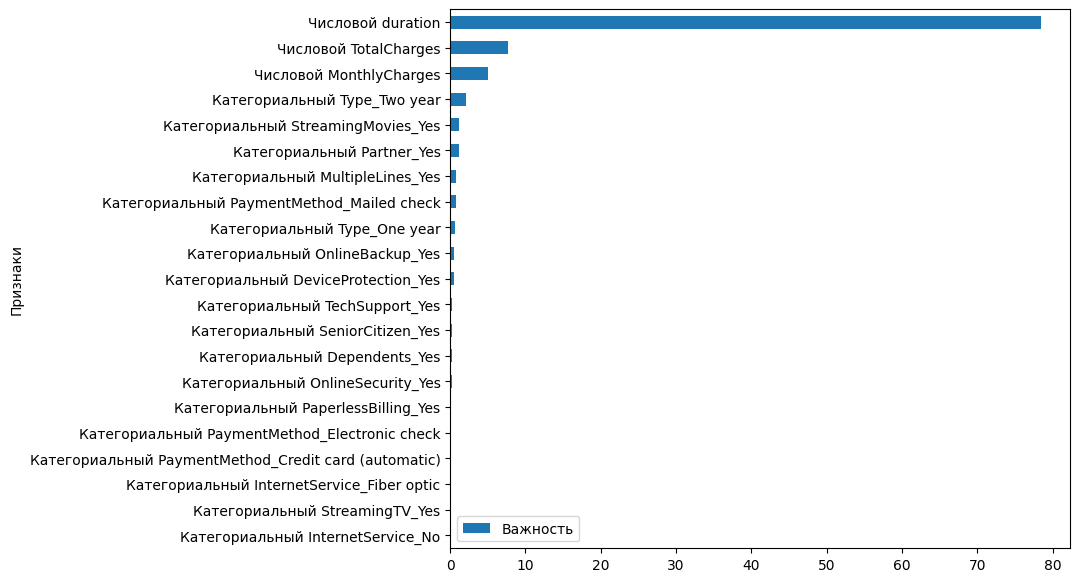

In [54]:
feature_importance = pd.DataFrame(
    data= {
        'Признаки': list(map(lambda x: x.replace('onehotencoder__', 'Категориальный ')
                                       .replace('remainder__', 'Числовой '),
                            gs_cat.best_estimator_['columntransformer'].get_feature_names_out())),
        'Важность': best_model.feature_importances_
        
    }
)

feature_importance.sort_values('Важность').set_index('Признаки').plot.barh(figsize=(8, 7))


Самыми важными в обучении модели оказались 3 числовых признака количество дней пользования услугами duration, оплата в месяц MonthlyCharges, общая оплата TotalCharges и категориальный с данными о типе договора на 2 года. Наибольшее влияние оказал созданный признак duration.

Признаки относящиеся к дополнительным услугам(стриминговое тв, подключение телефона к нескольким линиям, антивирус, облачное хранилище), наличии партнёра, а также тип заключённого договора на год имеют более низкую значимость

Признаки о наличии иждевенцев, пенсионного статуса, наличии интернета, его характеристик и обслуживания, способа оплаты и отправки чеков почти не имеют значимости.

***Вывод***

Модель Катбуст показала хорошие результаты на тестовой выборке:
- roc_auc на test 0.87
- accuracy на test:  0.89

По матрице ошибок видно, что модель хорошо справляется с определением клиентов, которые хотят отказаться от услуг оператора, а также клиентов, которые не планируют отказываться от услуг.\
Модель выдаёт ошибки в размере 10%. Из них большая часть происходит в определении клиентов, которые не планируют отказываться от услуг, что также является её сильной стороной.

# Отчёт

В ходе работы над проетом были проведены:
- исследовательский анализ данных
- предобработка
- обучение 3 моделей и тестирование лучшей из них
- анализ результатов

Все запланированные шаги были выполнены, а цели поставленные в начале проекта достигнуты.

Наибольшую сложность в проекте для меня составио создание моделей, которые бы не допускали утечек данных при кросс-валидации. Благодаря использованию конвейеров, удалось решить эту проблему.

Список признаков:\
Предоставленные заказчиком
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга/супруги
- Dependents - наличие иждивенцев
- Type - тип договора: ежемесячный, годовой и т.д
- PaperlessBilling - выставления счёта по электронной почте
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги
- InternetService - наличие услуг Интернет
- OnlineSecurity - межсетевой экран
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - антивирус
- TechSupport - выделенная линия технической поддержки
- StreamingTV - онлайн-ТВ
- StreamingMovies - онлайн-кинотеатр
- MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно

Созданные на основе предоставленных данных
- enjoys - целевой признак, показывающий пользуется клиент услугами оператора или уже нет
- duration - сколько дней клиент пользовался услугами оператора

После анализа данных была проведена предобработка. На этом этапе мы обработали пропуски, исследовали коллениарность, изменили типы данных, добавили новые признаки, удалили ненужные, разделили и закодировали готовый датасет.

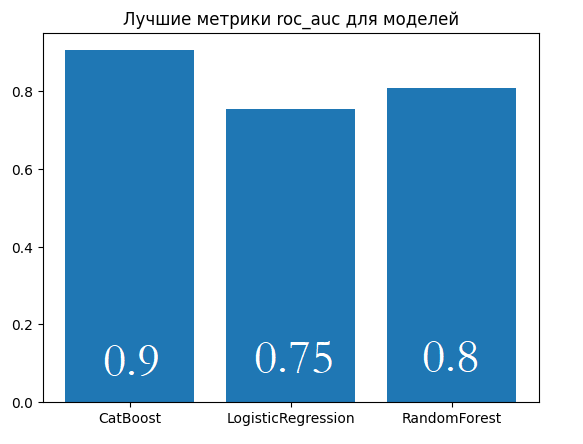

Лучшей моделью стала CatBoost. Её roc-auc на обучающей выборке составил 0.9\
параметры: learning_rate: 0.6, max_depth: 2

На тестовой выборке она также показала хороший результат.\
auc-roc модели составил 0.869\
Её accurasy 0.897\
Модель ошибается всего в 10% случаев

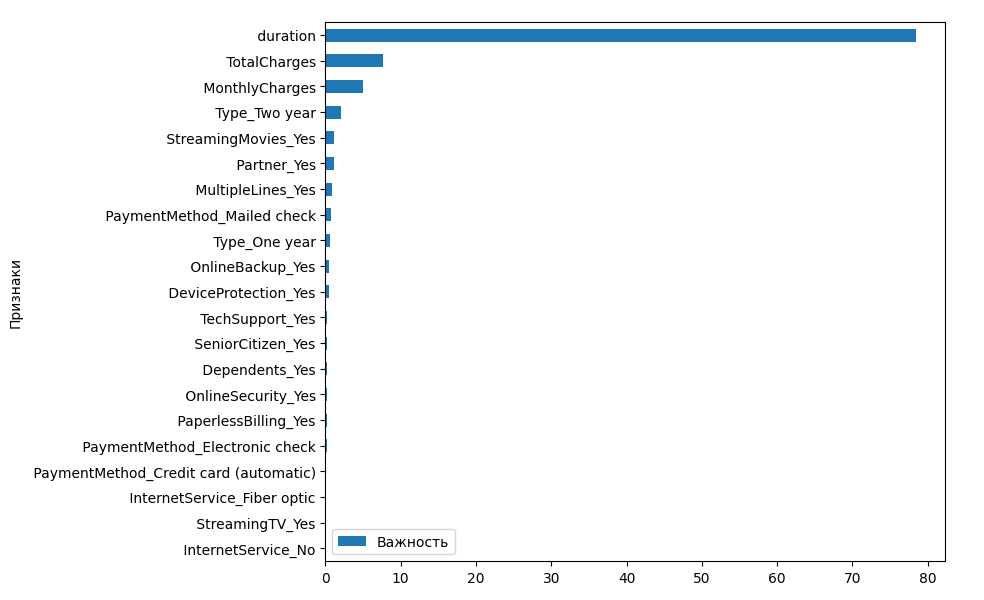

Самыми важными в обучении модели оказались 3 числовых признака количество дней пользования услугами duration, оплата в месяц MonthlyCharges, общая оплата TotalCharges и категориальный с данными о типе договора на 2 года. Наибольшее влияние оказал созданный признак duration.

Признаки относящиеся к дополнительным услугам(стриминговое тв, подключение телефона к нескольким линиям, антивирус, облачное хранилище), наличии партнёра, а также тип заключённого договора на год имеют более низкую значимость

Признаки о наличии иждевенцев, пенсионного статуса, наличии интернета, его характеристик и обслуживания, способа оплаты и отправки чеков почти не имеют значимости.

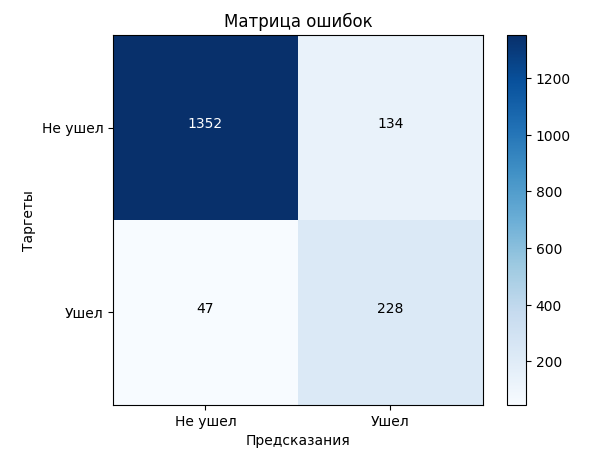

Посмотрев на матрицу ошибок можно увидеть, что модель хорошо справляется с определением клиентов, которые хотят отказаться от услуг оператора, а также клиентов, которые не планируют отказываться от услуг.

Значение accurasy 0.897 говорит нам о том, что модель выдаёт ошибочные предсказания в размере 10%. Из них 7.3% происходят в определении клиентов, которые не планируют отказываться от услуг, но модель оценила их как потенциально ушедших. Это также является её сильной стороной, так как в практике предложить бонус клиенту не собирающемуся уходить скорее положительно повлияет на его лояльность к продукту, чем сподвигнет его отказаться от услуг.

И только в 2.6% она совершает более серьёзную для целей ошибку: "не видит" клиента, который откажется от услуг.